In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 30
BATCH_SIZE = 256
CLASS_WEIGHT=[1, 1, 1]
HIDDEN_DIM=64
#
MAX_LEN = 400

# Data Upload

In [4]:
df = pd.read_csv('TrLlama_HateSpeech.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

etiket                     55
tweet                       0
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
etiket                     0
tweet                      0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7877
nefret       6006
saldırgan    2680
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7877, 'nefret': 6006, 'saldırgan': 2680})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 14906
x_test 1657
y_train 14906
y_test 1657
Number of unique classes in y_test: 3


In [25]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [29]:
model_name='bahdanau_FT-W2V'

In [30]:
attention= 'additive'

In [31]:
OUTPUT_DIM =len(set(y))

In [32]:
from train.trainSeq2Seq import train_seq2seq_model

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0267, F1: 0.2380 | Val_Loss: 1.0225, Val_F1: 0.2092
Epoch 02 | Loss: 1.0075, F1: 0.2435 | Val_Loss: 1.0089, Val_F1: 0.2451
Epoch 03 | Loss: 0.9889, F1: 0.3044 | Val_Loss: 0.9871, Val_F1: 0.3292
Epoch 04 | Loss: 0.9663, F1: 0.3529 | Val_Loss: 0.9663, Val_F1: 0.3717
Epoch 05 | Loss: 0.9380, F1: 0.3878 | Val_Loss: 0.9458, Val_F1: 0.3844
Epoch 06 | Loss: 0.8981, F1: 0.4229 | Val_Loss: 0.9110, Val_F1: 0.4200
Epoch 07 | Loss: 0.8472, F1: 0.4619 | Val_Loss: 0.8699, Val_F1: 0.4710
Epoch 08 | Loss: 0.7970, F1: 0.4890 | Val_Loss: 0.8593, Val_F1: 0.4551
Epoch 09 | Loss: 0.7467, F1: 0.5211 | Val_Loss: 0.8072, Val_F1: 0.5023
Epoch 10 | Loss: 0.7053, F1: 0.5456 | Val_Loss: 0.7851, Val_F1: 0.5105
Epoch 11 | Loss: 0.6607, F1: 0.5769 | Val_Loss: 0.7746, Val_F1: 0.5152
Epoch 12 | Loss: 0.6274, F1: 0.5883 | Val_Loss: 0.7541, Val_F1: 0.5317
Epoch 13 | Loss: 0.5925, F1: 0.6102 | Val_Loss: 0.7403, Val_F1: 0.5905
Epoch 14 | Loss: 0.5579, F1: 0.6481 | Val_Loss: 0.7385, Val_F1: 0.5986
Epoch 

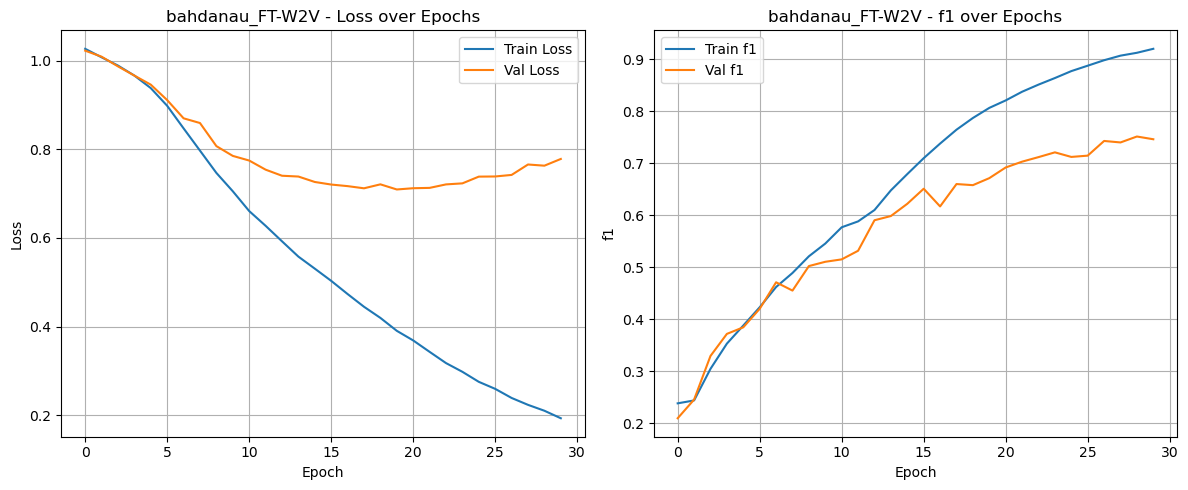

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [33]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FT-W2V
Accuracy  : 0.7640
Precision : 0.7696
Recall    : 0.7326
F1 Score  : 0.7464


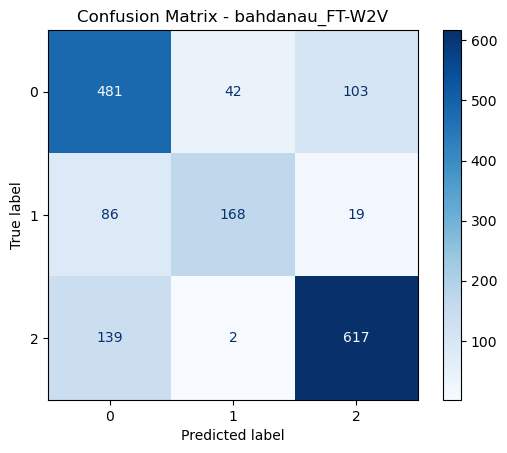

📌 Confusion matrix saved to: plots/saved/bahdanau_FT-W2V_csmtx.png


In [34]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [35]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [36]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 0
⚡ Inference Time for one sample : 3.83 ms


In [37]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [38]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.764031382015691],
 'Precision': [0.7695559965459157],
 'Recall': [0.732579797092935],
 'F1': [0.7464403415460167],
 'Train_Time': [86373.15249443054],
 'Infer_Time': [3.831148147583008]}

# AdditiveAttention + FreeEmbedding

In [40]:
model_name='bahdanau_FE'

In [41]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0249, F1: 0.2356 | Val_Loss: 1.0213, Val_F1: 0.2092
Epoch 02 | Loss: 1.0105, F1: 0.2266 | Val_Loss: 1.0167, Val_F1: 0.2115
Epoch 03 | Loss: 1.0033, F1: 0.2489 | Val_Loss: 1.0042, Val_F1: 0.3003
Epoch 04 | Loss: 0.9887, F1: 0.3077 | Val_Loss: 0.9945, Val_F1: 0.2882
Epoch 05 | Loss: 0.9695, F1: 0.3444 | Val_Loss: 0.9734, Val_F1: 0.3559
Epoch 06 | Loss: 0.9479, F1: 0.3815 | Val_Loss: 0.9538, Val_F1: 0.3935
Epoch 07 | Loss: 0.9276, F1: 0.4151 | Val_Loss: 0.9396, Val_F1: 0.4128
Epoch 08 | Loss: 0.9035, F1: 0.4447 | Val_Loss: 0.9195, Val_F1: 0.4368
Epoch 09 | Loss: 0.8796, F1: 0.4674 | Val_Loss: 0.9013, Val_F1: 0.4484
Epoch 10 | Loss: 0.8560, F1: 0.4908 | Val_Loss: 0.8869, Val_F1: 0.4899
Epoch 11 | Loss: 0.8281, F1: 0.5143 | Val_Loss: 0.8703, Val_F1: 0.4924
Epoch 12 | Loss: 0.7989, F1: 0.5358 | Val_Loss: 0.8556, Val_F1: 0.5047
Epoch 13 | Loss: 0.7752, F1: 0.5603 | Val_Loss: 0.8433, Val_F1: 0.5062
Epoch 14 | Loss: 0.7493, F1: 0.5805 | Val_Loss: 0.8290, Val_F1: 0.5309
Epoch 

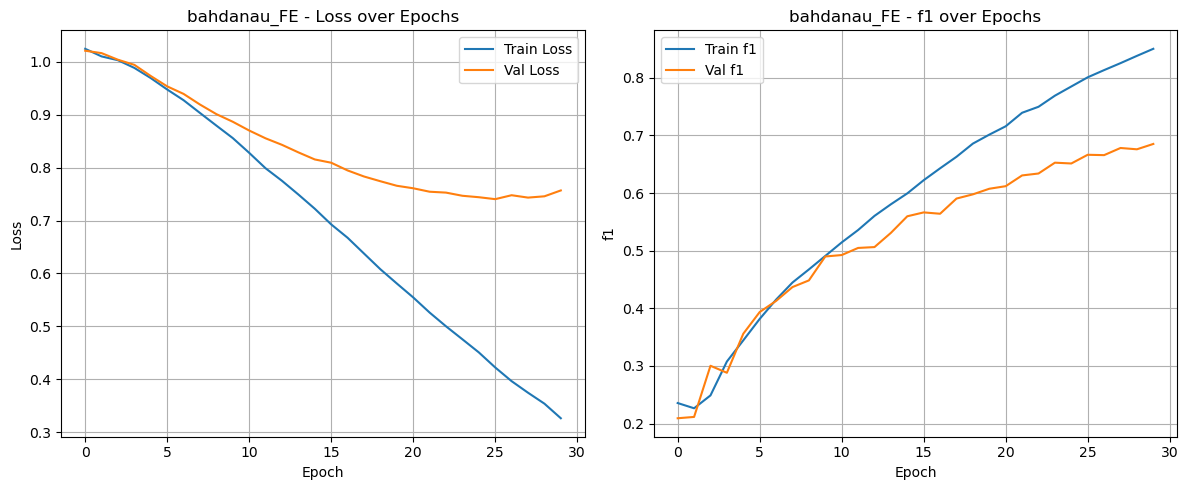

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [42]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.7145
Precision : 0.6889
Recall    : 0.6833
F1 Score  : 0.6852


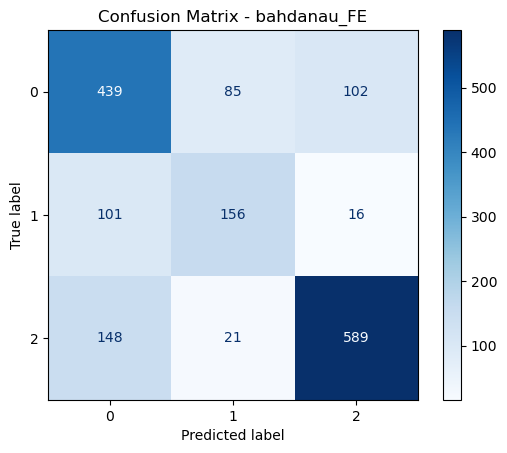

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [43]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [44]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 2.02 ms


In [45]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [47]:
model_name='Luong_FT-W2V'

In [48]:
attention= 'dot'

In [49]:
from transformer_model.attention import DotProductAttention
attention = DotProductAttention()

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0281, F1: 0.2345 | Val_Loss: 1.0187, Val_F1: 0.2092
Epoch 02 | Loss: 1.0079, F1: 0.2327 | Val_Loss: 1.0097, Val_F1: 0.2438
Epoch 03 | Loss: 0.9936, F1: 0.2989 | Val_Loss: 0.9882, Val_F1: 0.3429
Epoch 04 | Loss: 0.9731, F1: 0.3552 | Val_Loss: 0.9671, Val_F1: 0.3810
Epoch 05 | Loss: 0.9487, F1: 0.3804 | Val_Loss: 0.9468, Val_F1: 0.3936
Epoch 06 | Loss: 0.9174, F1: 0.4030 | Val_Loss: 0.9161, Val_F1: 0.4089
Epoch 07 | Loss: 0.8726, F1: 0.4333 | Val_Loss: 0.8783, Val_F1: 0.4290
Epoch 08 | Loss: 0.8271, F1: 0.4712 | Val_Loss: 0.8433, Val_F1: 0.4734
Epoch 09 | Loss: 0.7773, F1: 0.4968 | Val_Loss: 0.8076, Val_F1: 0.4816
Epoch 10 | Loss: 0.7302, F1: 0.5251 | Val_Loss: 0.8179, Val_F1: 0.4787
Epoch 11 | Loss: 0.6932, F1: 0.5382 | Val_Loss: 0.7591, Val_F1: 0.5102
Epoch 12 | Loss: 0.6508, F1: 0.5638 | Val_Loss: 0.7421, Val_F1: 0.5194
Epoch 13 | Loss: 0.6147, F1: 0.5800 | Val_Loss: 0.7348, Val_F1: 0.5304
Epoch 14 | Loss: 0.5821, F1: 0.6105 | Val_Loss: 0.7155, Val_F1: 0.5446
Epoch 

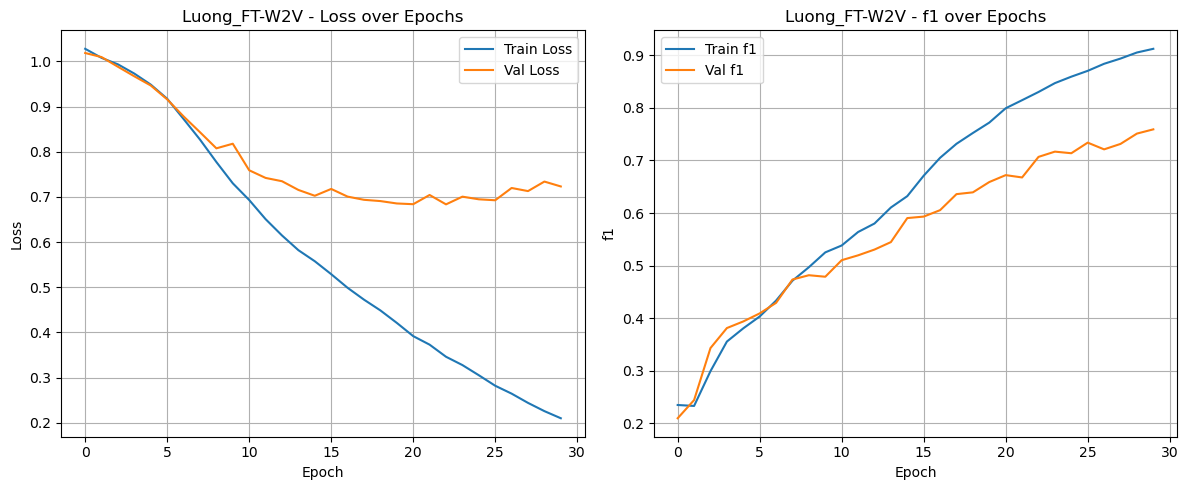

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [50]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.7797
Precision : 0.7736
Recall    : 0.7492
F1 Score  : 0.7593


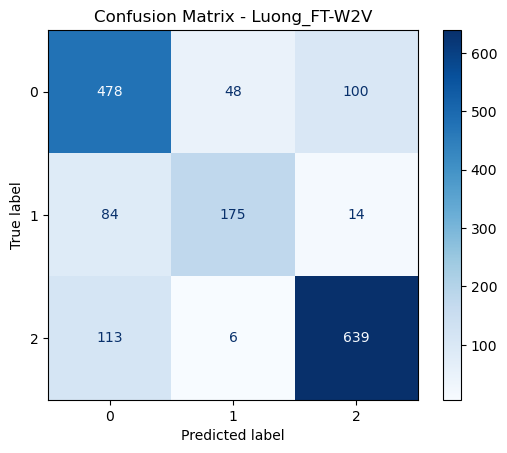

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [51]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [52]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 2.02 ms


In [53]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [55]:
model_name='Luong_FE'

In [56]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0270, F1: 0.2485 | Val_Loss: 1.0228, Val_F1: 0.2092
Epoch 02 | Loss: 1.0114, F1: 0.2198 | Val_Loss: 1.0169, Val_F1: 0.2092
Epoch 03 | Loss: 1.0038, F1: 0.2372 | Val_Loss: 1.0088, Val_F1: 0.2091
Epoch 04 | Loss: 0.9858, F1: 0.2803 | Val_Loss: 0.9895, Val_F1: 0.3037
Epoch 05 | Loss: 0.9657, F1: 0.3576 | Val_Loss: 0.9720, Val_F1: 0.3531
Epoch 06 | Loss: 0.9440, F1: 0.4112 | Val_Loss: 0.9541, Val_F1: 0.3963
Epoch 07 | Loss: 0.9233, F1: 0.4380 | Val_Loss: 0.9378, Val_F1: 0.4187
Epoch 08 | Loss: 0.8990, F1: 0.4646 | Val_Loss: 0.9279, Val_F1: 0.4212
Epoch 09 | Loss: 0.8771, F1: 0.4876 | Val_Loss: 0.9037, Val_F1: 0.4602
Epoch 10 | Loss: 0.8533, F1: 0.5074 | Val_Loss: 0.8885, Val_F1: 0.4876
Epoch 11 | Loss: 0.8230, F1: 0.5435 | Val_Loss: 0.8724, Val_F1: 0.4771
Epoch 12 | Loss: 0.7954, F1: 0.5578 | Val_Loss: 0.8548, Val_F1: 0.4912
Epoch 13 | Loss: 0.7691, F1: 0.5804 | Val_Loss: 0.8416, Val_F1: 0.5123
Epoch 14 | Loss: 0.7403, F1: 0.6078 | Val_Loss: 0.8264, Val_F1: 0.5386
Epoch 

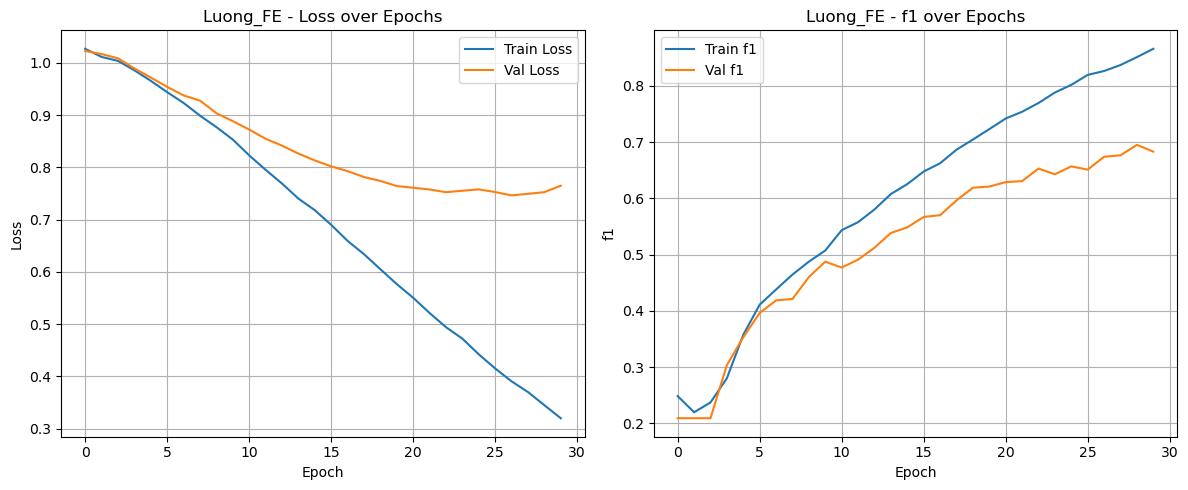

📈 Training history saved to: plots/saved/Luong_FE_plot.png


In [57]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FE
Accuracy  : 0.7133
Precision : 0.7202
Recall    : 0.6678
F1 Score  : 0.6831


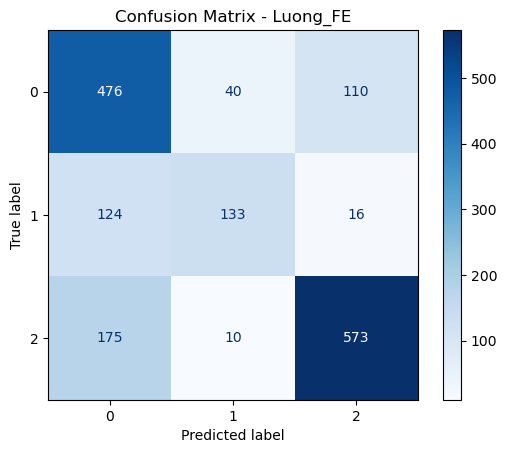

📌 Confusion matrix saved to: plots/saved/Luong_FE_csmtx.png


In [58]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [59]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 2.00 ms


In [60]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FT-W2V

In [62]:
model_name='scaled-dot_FT-W2V'

In [63]:
attention= 'scaled_dot'

In [64]:
from transformer_model.attention import ScaledDotProductAttention
attention = ScaledDotProductAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0250, F1: 0.2394 | Val_Loss: 1.0195, Val_F1: 0.2092
Epoch 02 | Loss: 1.0062, F1: 0.2380 | Val_Loss: 1.0078, Val_F1: 0.2446
Epoch 03 | Loss: 0.9890, F1: 0.3159 | Val_Loss: 0.9872, Val_F1: 0.3359
Epoch 04 | Loss: 0.9613, F1: 0.3610 | Val_Loss: 0.9585, Val_F1: 0.3888
Epoch 05 | Loss: 0.9219, F1: 0.4020 | Val_Loss: 0.9263, Val_F1: 0.4154
Epoch 06 | Loss: 0.8783, F1: 0.4315 | Val_Loss: 0.8947, Val_F1: 0.4331
Epoch 07 | Loss: 0.8301, F1: 0.4570 | Val_Loss: 0.8611, Val_F1: 0.4478
Epoch 08 | Loss: 0.7815, F1: 0.4788 | Val_Loss: 0.8324, Val_F1: 0.4568
Epoch 09 | Loss: 0.7347, F1: 0.5009 | Val_Loss: 0.8124, Val_F1: 0.4669
Epoch 10 | Loss: 0.6910, F1: 0.5208 | Val_Loss: 0.7917, Val_F1: 0.4813
Epoch 11 | Loss: 0.6556, F1: 0.5547 | Val_Loss: 0.7705, Val_F1: 0.5111
Epoch 12 | Loss: 0.6183, F1: 0.5732 | Val_Loss: 0.7587, Val_F1: 0.5161
Epoch 13 | Loss: 0.5873, F1: 0.5975 | Val_Loss: 0.7524, Val_F1: 0.5368
Epoch 14 | Loss: 0.5571, F1: 0.6291 | Val_Loss: 0.7642, Val_F1: 0.5299
Epoch 

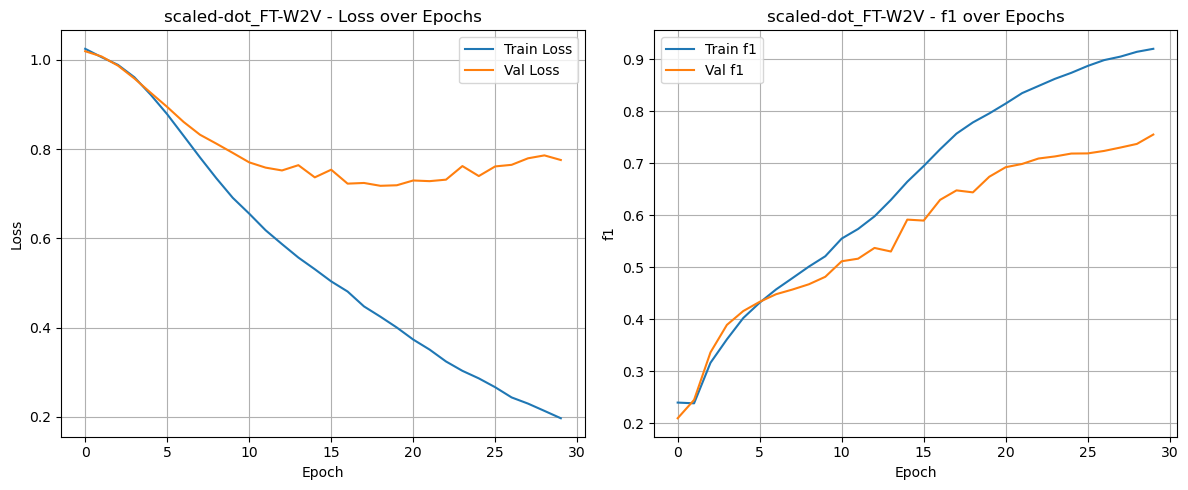

📈 Training history saved to: plots/saved/scaled-dot_FT-W2V_plot.png


In [65]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FT-W2V
Accuracy  : 0.7725
Precision : 0.7641
Recall    : 0.7475
F1 Score  : 0.7548


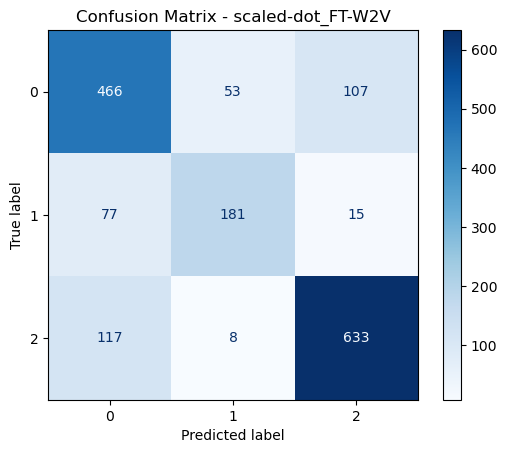

📌 Confusion matrix saved to: plots/saved/scaled-dot_FT-W2V_csmtx.png


In [66]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [67]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 0
⚡ Inference Time for one sample : 2.50 ms


In [68]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FE

In [70]:
model_name='scaled-dot_FE'

In [71]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0273, F1: 0.2700 | Val_Loss: 1.0260, Val_F1: 0.2092
Epoch 02 | Loss: 1.0130, F1: 0.2285 | Val_Loss: 1.0217, Val_F1: 0.2092
Epoch 03 | Loss: 1.0047, F1: 0.2394 | Val_Loss: 1.0108, Val_F1: 0.2266
Epoch 04 | Loss: 0.9923, F1: 0.2803 | Val_Loss: 0.9985, Val_F1: 0.2980
Epoch 05 | Loss: 0.9757, F1: 0.3489 | Val_Loss: 0.9850, Val_F1: 0.3449
Epoch 06 | Loss: 0.9558, F1: 0.4004 | Val_Loss: 0.9714, Val_F1: 0.3780
Epoch 07 | Loss: 0.9322, F1: 0.4273 | Val_Loss: 0.9532, Val_F1: 0.4123
Epoch 08 | Loss: 0.9087, F1: 0.4540 | Val_Loss: 0.9419, Val_F1: 0.4117
Epoch 09 | Loss: 0.8858, F1: 0.4780 | Val_Loss: 0.9192, Val_F1: 0.4507
Epoch 10 | Loss: 0.8577, F1: 0.5023 | Val_Loss: 0.9045, Val_F1: 0.4638
Epoch 11 | Loss: 0.8289, F1: 0.5377 | Val_Loss: 0.8914, Val_F1: 0.4775
Epoch 12 | Loss: 0.8055, F1: 0.5579 | Val_Loss: 0.8764, Val_F1: 0.5057
Epoch 13 | Loss: 0.7768, F1: 0.5859 | Val_Loss: 0.8654, Val_F1: 0.5155
Epoch 14 | Loss: 0.7497, F1: 0.5995 | Val_Loss: 0.8554, Val_F1: 0.5352
Epoch 

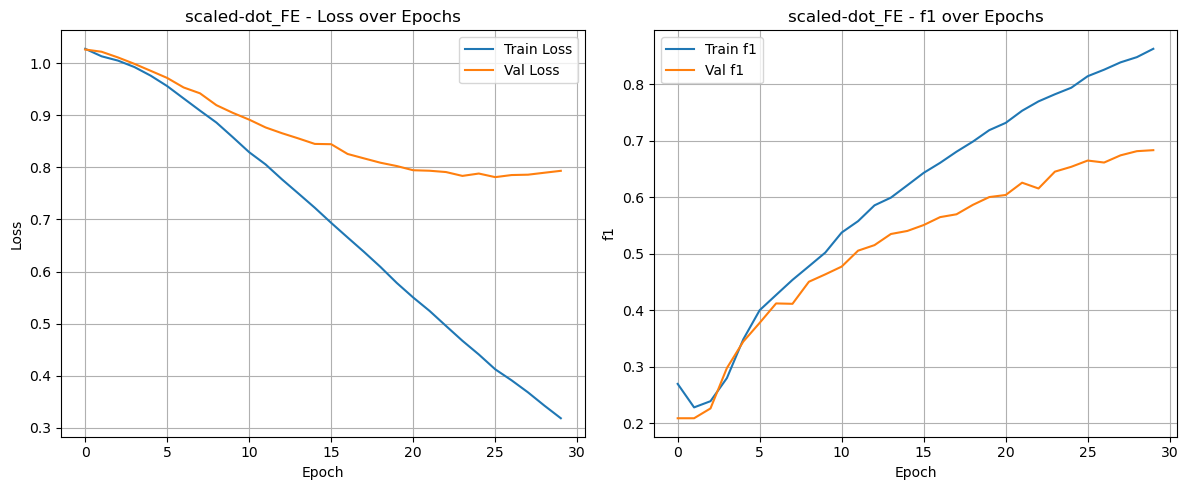

📈 Training history saved to: plots/saved/scaled-dot_FE_plot.png


In [72]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FE
Accuracy  : 0.7109
Precision : 0.7077
Recall    : 0.6701
F1 Score  : 0.6835


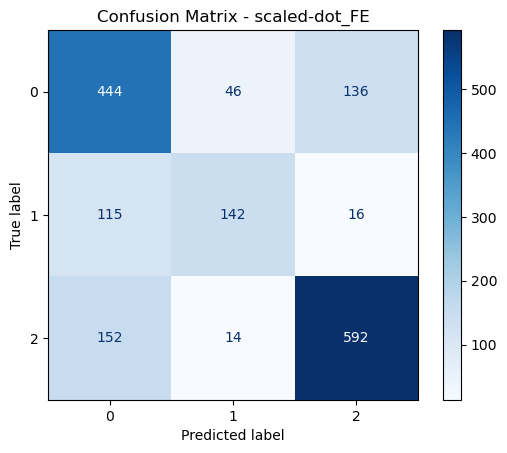

📌 Confusion matrix saved to: plots/saved/scaled-dot_FE_csmtx.png


In [73]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [74]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.80 ms


In [75]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# result

In [77]:
main_result

{'model_name': ['bahdanau_FT-W2V',
  'bahdanau_FE',
  'Luong_FT-W2V',
  'Luong_FE',
  'scaled-dot_FT-W2V',
  'scaled-dot_FE'],
 'Accuracy': [0.764031382015691,
  0.7145443572721787,
  0.7797223898611949,
  0.7133373566686784,
  0.7724803862401931,
  0.7109233554616777],
 'Precision': [0.7695559965459157,
  0.6888662793836383,
  0.7736486218584608,
  0.7202373313138787,
  0.7641350287948723,
  0.7077139318668495],
 'Recall': [0.732579797092935,
  0.6832504605271345,
  0.7492039437844357,
  0.6678331830742327,
  0.7475016523251748,
  0.6701381114625992],
 'F1': [0.7464403415460167,
  0.6851539566384256,
  0.7592760034010961,
  0.6831318888312446,
  0.7547962140121411,
  0.6834501833113329],
 'Train_Time': [86373.15249443054,
  82153.91612052917,
  83637.15600967407,
  83606.90093040466,
  83191.08152389526,
  81567.30246543884],
 'Infer_Time': [3.831148147583008,
  2.023458480834961,
  2.0170211791992188,
  1.9969940185546875,
  2.5043487548828125,
  0.8029937744140625]}

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Model Performance Metrics'}, ylabel='Value'>,
  <Axes: title={'center': 'Model Training and Inference Times'}, xlabel='Model', ylabel='Training Time (seconds)'>,
  <Axes: ylabel='Inference Time (seconds)'>))

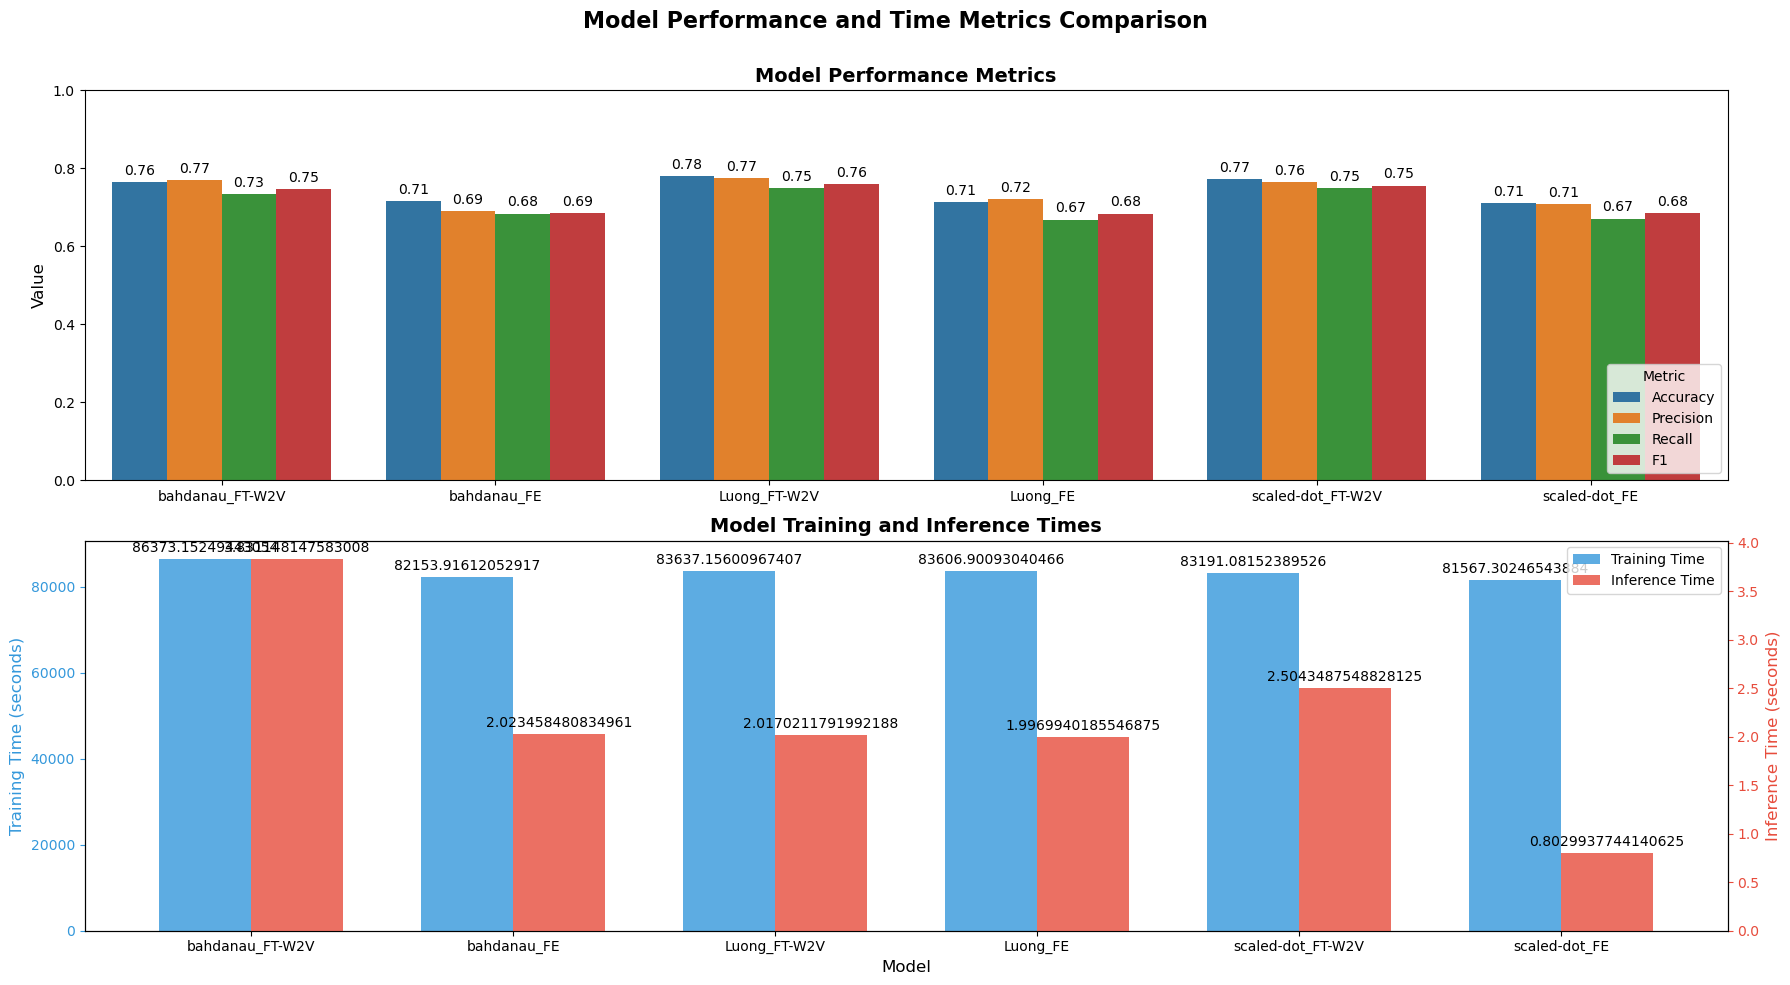

In [78]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Metrics Comparison'}, xlabel='Model', ylabel='Value'>)

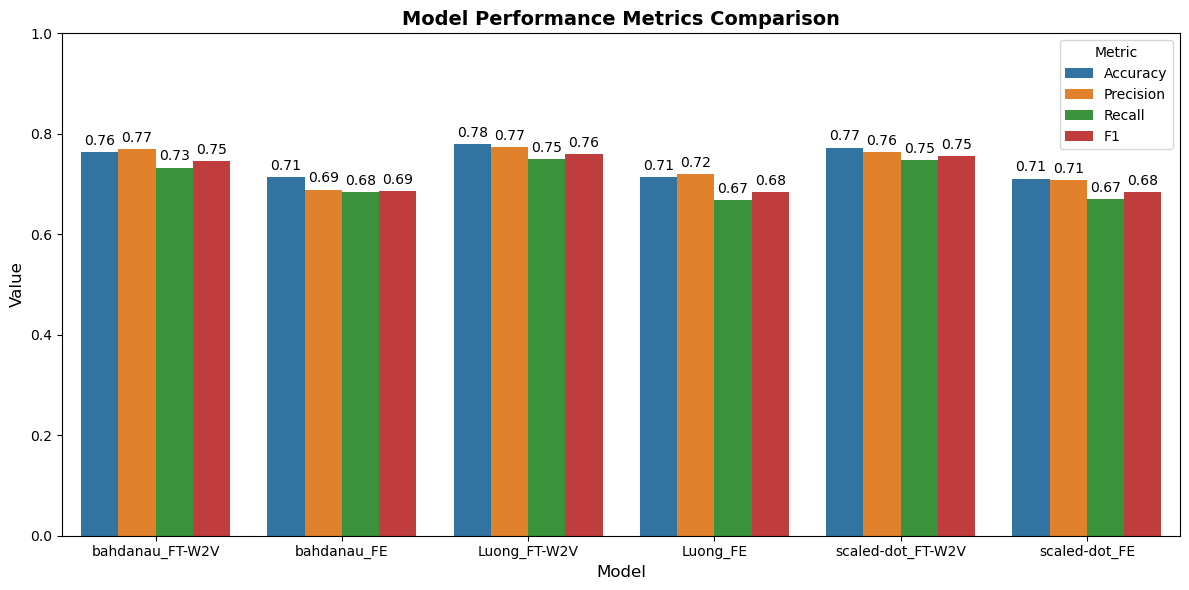

In [79]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [80]:
# AdditiveAttention + FT-W2V